In [11]:
import YOLO_utils

from pathlib import Path
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline
import numpy as np
import random, time

import tensorflow as tf

# keras as a layer on top of tensorflow
from keras.models import Sequential, Model
from keras.layers import Reshape, Activation, Conv2D, Input, MaxPooling2D, BatchNormalization, Flatten, Dense, Lambda
from keras.layers import LeakyReLU

## Load Zenodo images and weights

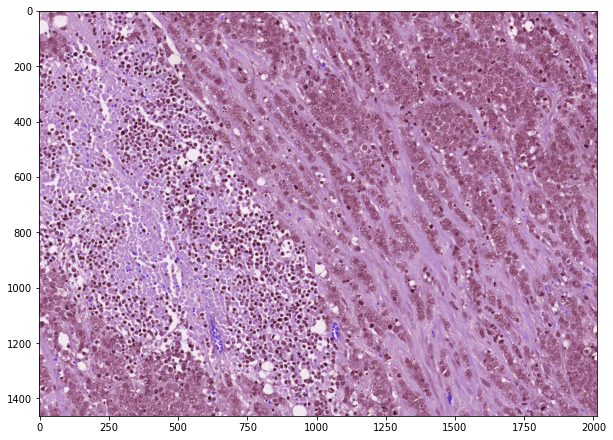

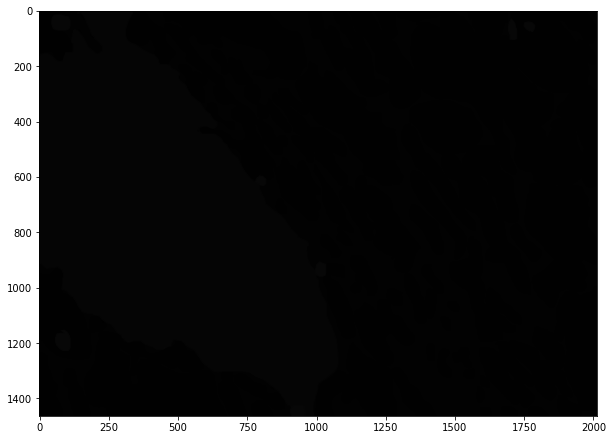

In [12]:
from os import listdir

workdir = Path(".")

# Define directory of training images
images_dir = workdir / 'roi-level-annotations' / 'tissue-bcss' / 'images'
masks_dir = workdir / 'roi-level-annotations' / 'tissue-bcss' / 'masks'

# Pick random training image
case_image = images_dir / listdir(images_dir)[0]
case_filename = Path(case_image.name).with_suffix('.xml')

# Open image with opencv and visualize it
image = cv2.imread(str(case_image))
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.show()

# Pick random training image
case_mask = masks_dir / listdir(masks_dir)[0]
case_filename_mask = Path(case_mask.name).with_suffix('.xml')

# Open image with opencv and visualize it
mask = cv2.imread(str(case_mask))
plt.figure(figsize=(10,10))
plt.imshow(mask)
plt.show()

In [13]:
print(image.shape)
print(mask.shape)

(1463, 2015, 3)
(1463, 2015, 3)


## YOLO network

In [14]:
# Set the parameters 

LABELS = ['Lym', 'Plasma']

#Check these parameters
IMAGE_H, IMAGE_W = 256, 256
GRID_H,  GRID_W  = 32 , 32
###

BOX              = 5
CLASS            = len(LABELS)
CLASS_WEIGHTS    = np.ones(CLASS, dtype='float32')
OBJ_THRESHOLD    = 0.3
NMS_THRESHOLD    = 0.3
ANCHORS          = [0.57273, 0.677385, 1.87446, 2.06253, 3.33843, 5.47434, 7.88282, 3.52778, 9.77052, 9.16828]

NO_OBJECT_SCALE  = 1.0 # lambda noobj
OBJECT_SCALE     = 5.0 # lambda obj
COORD_SCALE      = 1.0
CLASS_SCALE      = 1.0

BATCH_SIZE       = 16
WARM_UP_BATCHES  = 100
TRUE_BOX_BUFFER  = 50

In [15]:
def space_to_depth_x2(x):
    return tf.nn.space_to_depth(x, block_size=2)

In [16]:
input_image = Input(shape=(IMAGE_H, IMAGE_W, 3))
true_boxes  = Input(shape=(1, 1, 1, TRUE_BOX_BUFFER , 4))

In [17]:
model = YOLO.YOLO_network(input_image, true_boxes, CLASS, BOX, GRID_H, GRID_W)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv_1 (Conv2D)                (None, 256, 256, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 norm_1 (BatchNormalization)    (None, 256, 256, 32  128         ['conv_1[0][0]']                 
                                )                                                           

In [18]:
# Define directory of test images
test_dir = workdir / 'roi-level-annotations' / 'tissue-bcss' / 'images'

# Pick a random test file
test_img = test_dir / random.choice(listdir(test_dir))

# Process image
t_start = time.time()
print(f"Processing {test_img}")
image = cv2.imread(str(test_img))
image.resize(256,256,3)
input_image = image / np.max(image) # rescale intensity to [0, 1]
input_image = input_image[:,:,::-1]
img_shape = image.shape
input_image = np.expand_dims(input_image, 0) 

# Define variable needed to process input image
dummy_array = np.zeros((1,1,1,1,TRUE_BOX_BUFFER,4))

# Get output from network
netout = model.predict([input_image, dummy_array])

print('Processing one breast digital pathology took {} seconds'.format(time.time() - t_start))

Processing roi-level-annotations\tissue-bcss\images\TCGA-C8-A131-01Z-00-DX1.5CB27A29-9951-40B9-B4DB-26A4D2EA89B8_[21527, 5449, 23121, 6792].png
Processing one breast digital pathology took 0.1780390739440918 seconds


In [19]:
print(netout.shape)

(1, 32, 32, 5, 7)


In [ ]:
# define a threshold to apply to predictions
obj_threshold=0.05

boxes = YOLO.predict_bounding_box(test_img, model, obj_threshold, NMS_THRESHOLD, ANCHORS, CLASS, TRUE_BOX_BUFFER)

# get matplotlib bbox objects
plt_boxes = YOLO.get_matplotlib_boxes(boxes, img_shape)

# visualize result
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, aspect='equal')
plt.imshow(cv2.imread(str(test_img)), cmap='gray')
for plt_box in plt_boxes:
    ax.add_patch(plt_box)
plt.show()

In [ ]:
#Check paper (feat Francesco) https://openreview.net/pdf?id=S10IfW2oz for YOLO architecture 